In [14]:
import pandas as pd
import numpy as np
import re
import nltk 
import spacy
import matplotlib.pyplot as plt

#for data cleaning and preprocessing
from nltk.corpus import stopwords

#for bigrams and trigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser

#for bow building
from gensim.corpora.dictionary import Dictionary

#lda, valutazione lda e visualizzazione lda
from gensim.models.ldamodel import LdaModel
from gensim.models.ldamodel import CoherenceModel
import pyLDAvis.gensim_models as gensimvis

#for last conclusions on labels of interest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [15]:
df=pd.read_csv("data.csv")
id_list=list(np.unique(df.id))
name_list=list(np.unique(df.names))
name_list

['Ark Nova',
 'Brass: Birmingham',
 'Dune: Imperium',
 'Gloomhaven',
 'Pandemic Legacy: Season 1',
 'Spirit Island',
 'Star Wars: Rebellion',
 'Terraforming Mars',
 'Twilight Imperium: Fourth Edition',
 'War of the Ring: Second Edition']

#### Data Cleaning and preprocessing functions ####

In [16]:

nlp = spacy.load('en_core_web_sm')
stop_words = set(stopwords.words('english'))

def get_game_comments(game_name, df):
    # Filtra i commenti relativi al gioco specificato
    comments = df[df['names'].str.lower() == game_name.lower()]['comments'].dropna().tolist()
    return comments       

def clean_text(text):
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text.strip().lower()

def preprocess(text):
    tokens = nltk.SpaceTokenizer().tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

def lemmatize(tokens):
    doc = nlp(' '.join(tokens))
    return [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB']]

def create_bigram(df_pre):
    bigram = Phrases(df_pre, min_count=5, threshold=100)
    bigram_model = Phraser(bigram)
    bigram_df = [bigram_model[doc] for doc in df_pre]
    return bigram_df

def create_corpus(bigram_df):
    global global_dictionary 
    global_dictionary = Dictionary(bigram_df)
    corpus = [global_dictionary.doc2bow(doc) for doc in bigram_df]
    return corpus

def train_lda(corpus,dict,ntopics,random_state):
    ldamodel = LdaModel(corpus=corpus,id2word=dict,num_topics=ntopics,random_state=random_state)
    return ldamodel

def compute_coherence(lda_model, texts, dictionary):
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def clean_filename(name):
    # per salvare correttamente anche i giochi con punteggiatura nel nome
    return re.sub(r'[\\/*?:"<>|&]', '_', name)


In [4]:
#ci impiega un po', circa 6 minuti
matrix = []
for game in name_list:
    comments = get_game_comments(game, df)
    if comments:  
        matrix.append([lemmatize(preprocess(clean_text(j))) for j in comments])

In [6]:
def pipeline(matrix,name_list):   
    num_topics = 5  
    random_state = 42  
    lda_models = {} 
    corpora = []  
    dictionary_list = []
    coherence_scores ={}
    for i, game_comments in enumerate(matrix):
        if game_comments:
            #creo bigram per il gioco  
            bigram_comments = create_bigram(game_comments)  
            #creo il corpus sfruttando i bigram del gioco e lo salvo nella lista
            corpus = create_corpus(bigram_comments)  
            corpora.append(corpus)  
            #creo il dictionary sfruttando il corpus del gioco e lo salvo nella lista
            dictionary_list.append(global_dictionary)  
            #alleno il modello del gioco sfruttando corpus e dictionary precedentemente costruiti e salvo
            # il tutto nel dizionario lda_models
            lda_model = train_lda(corpus, global_dictionary, num_topics, random_state)
            lda_models[name_list[i]] = lda_model  
            #calcolo il coeherence score sul modello costruito, sfruttando i bigram e il dictionary costruiti precedentemente
            #salvo i valori in un dizionario coherence_scores che contenga i punteggi per ciascun gioco
            coherence_model = CoherenceModel(model=lda_model, texts=bigram_comments, dictionary=global_dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores[name_list[i]] = coherence_score
            #restituisco il necessario per il plot di PyLDAvis e i coeherence scores
    return lda_models,corpora,dictionary_list,coherence_scores


In [7]:
# Impiega circa 2 minuti
lda_models, corpora, dictionary_list, coherencescores = pipeline(matrix, name_list)

# Visualizza i modelli LDA per ciascun gioco e li salva in un apposito file html, sono riportati nella cartella
#lda_visualizations
#for i, game_name in enumerate(name_list):
    #cleaned_name = clean_filename(game_name) 
    #vis = gensimvis.prepare(lda_models[game_name], corpora[i], dictionary_list[i])
    #pyLDAvis.save_html(vis, 'lda_visualization_game_{}.html'.format(cleaned_name))

In [8]:
#in caso si volesse rappresentare uno dei giochi, basta passare alla seguente funzione i corretti parametri
#pyLDAvis.enable_notebook()
#vis = gensimvis.prepare(lda_models.get('Brass: Birmingham'), corpora[1], dictionary_list[1])
#pyLDAvis.display(vis)

In [9]:
for game_name, coherence_score in coherencescores.items():
    print(f"Coherence Score for {game_name}: {coherence_score}")

Coherence Score for Ark Nova: 0.46993278930104276
Coherence Score for Brass: Birmingham: 0.5966271071780531
Coherence Score for Dune: Imperium: 0.4990146717749385
Coherence Score for Gloomhaven: 0.4483501650118014
Coherence Score for Pandemic Legacy: Season 1: 0.5562287944063335
Coherence Score for Spirit Island: 0.5369340961735873
Coherence Score for Star Wars: Rebellion: 0.5665111539503297
Coherence Score for Terraforming Mars: 0.54757874725385
Coherence Score for Twilight Imperium: Fourth Edition: 0.4467359521321976
Coherence Score for War of the Ring: Second Edition: 0.493672378517349


In [ ]:
topics = {} 

for name in name_list:  
    topics[name] = [] 
    for i, topic in lda_models[name].show_topics(formatted=False):  
        topics[name].append(topic)

{'Ark Nova': [[('game', 0.057082556),
   ('card', 0.036453664),
   ('play', 0.03335133),
   ('action', 0.012592846),
   ('take', 0.011187119),
   ('good', 0.010726531),
   ('hour', 0.009462827),
   ('time', 0.009374686),
   ('feel', 0.008864059),
   ('animal', 0.008391672)],
  [('game', 0.071137056),
   ('play', 0.03505411),
   ('time', 0.020614939),
   ('card', 0.017840343),
   ('player', 0.015849845),
   ('mar', 0.010289407),
   ('get', 0.009921831),
   ('fun', 0.0086864),
   ('feel', 0.008623229),
   ('love', 0.00859684)],
  [('game', 0.027302569),
   ('map_pack', 0.024310142),
   ('good', 0.023955485),
   ('marine_world', 0.023311745),
   ('sleeve', 0.018829675),
   ('print', 0.011911033),
   ('include', 0.011887337),
   ('mar', 0.010365455),
   ('top', 0.008995619),
   ('expansion', 0.008830304)],
  [('game', 0.079652846),
   ('card', 0.032698978),
   ('play', 0.028311772),
   ('get', 0.014471668),
   ('great', 0.012581181),
   ('player', 0.012458013),
   ('feel', 0.012125006),
  

In [11]:
categories = {
    "luck/alea": ["dice", "draw", "random", "luck", "roll"],
    "bookkeeping": ["rule", "reference", "track", "management", "upkeep"],
    "downtime and duration": ["time", "wait", "turn", "long", "downtime"],
    "interaction": ["player", "attack", "influence", "steal", "trade"],
    "bash the leader": ["leader", "catch-up", "attack first", "balance"],
    "complicated vs complex": ["complex", "depth", "strategy", "mechanic", "rules"]
}


category_texts = {cat: " ".join(words) for cat, words in categories.items()}


topic_texts = []
topic_labels = [] 


for game, game_topics in topics.items():
    for i, topic in enumerate(game_topics):
        text = " ".join([word for word, _ in topic]) 
        topic_texts.append(text)
        topic_labels.append(f"{game} - Topic {i}")


all_texts = list(category_texts.values()) + topic_texts


vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)


category_vectors = tfidf_matrix[:len(categories)]
topic_vectors = tfidf_matrix[len(categories):]
similarities = cosine_similarity(topic_vectors, category_vectors)


df_results = pd.DataFrame(similarities, index=topic_labels, columns=categories.keys())

def get_max_categories(row):
    max_val = row.max()
    return ", ".join(row[row == max_val].index)

df_results["Assigned Category"] = df_results.apply(get_max_categories, axis=1)


df_results


,luck/alea,bookkeeping,downtime and duration,interaction,bash the leader,complicated vs complex,Assigned Category
Ark Nova - Topic 0,0.000000,0.000000,0.032978,0.000000,0.0,0.000000,downtime and duration
Ark Nova - Topic 1,0.000000,0.000000,0.039329,0.039329,0.0,0.000000,"downtime and duration, interaction"
Ark Nova - Topic 2,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,"luck/alea, bookkeeping, downtime and duration,..."
Ark Nova - Topic 3,0.256634,0.000000,0.000000,0.040284,0.0,0.000000,luck/alea
Ark Nova - Topic 4,0.000000,0.000000,0.000000,0.032377,0.0,0.000000,interaction
Brass: Birmingham - Topic 0,0.000000,0.000000,0.000000,0.032076,0.0,0.000000,interaction
Brass: Birmingham - Topic 1,0.000000,0.123573,0.034434,0.034434,0.0,0.000000,bookkeeping
Brass: Birmingham - Topic 2,0.000000,0.000000,0.000000,0.030636,0.0,0.000000,interaction
Brass: Birmingham - Topic 3,0.000000,0.000000,0.000000,0.029567,0.0,0.000000,interaction
Brass: Birmingham - Topic 4,0.000000,0.128685,0.035858,0.035858,0.0,0.227892,complicated vs complex


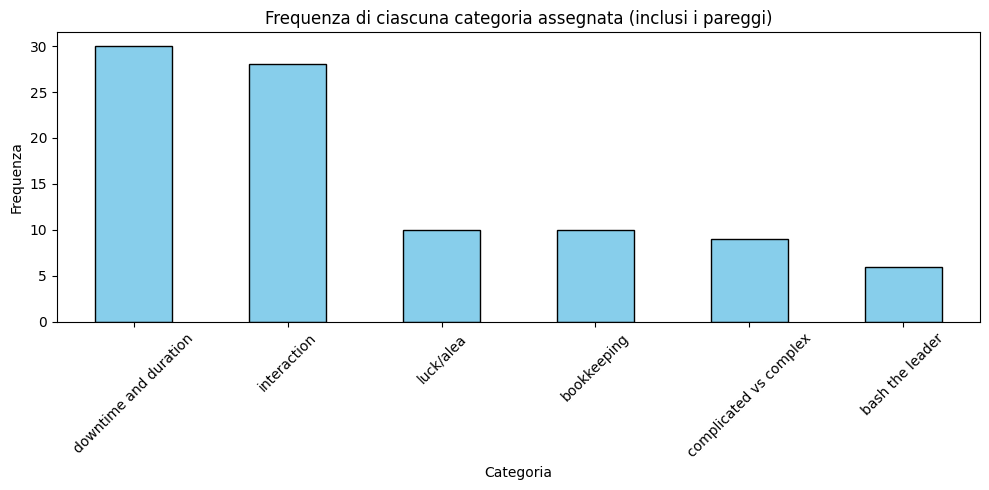

In [12]:
expanded = df_results["Assigned Category"].str.split(", ")

all_assigned = [cat for sublist in expanded for cat in sublist]

category_counts = pd.Series(all_assigned).value_counts().sort_values(ascending=False)

# Grafico a barre
plt.figure(figsize=(10, 5))
category_counts.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Frequenza di ciascuna categoria assegnata (inclusi i pareggi)")
plt.xlabel("Categoria")
plt.ylabel("Frequenza")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

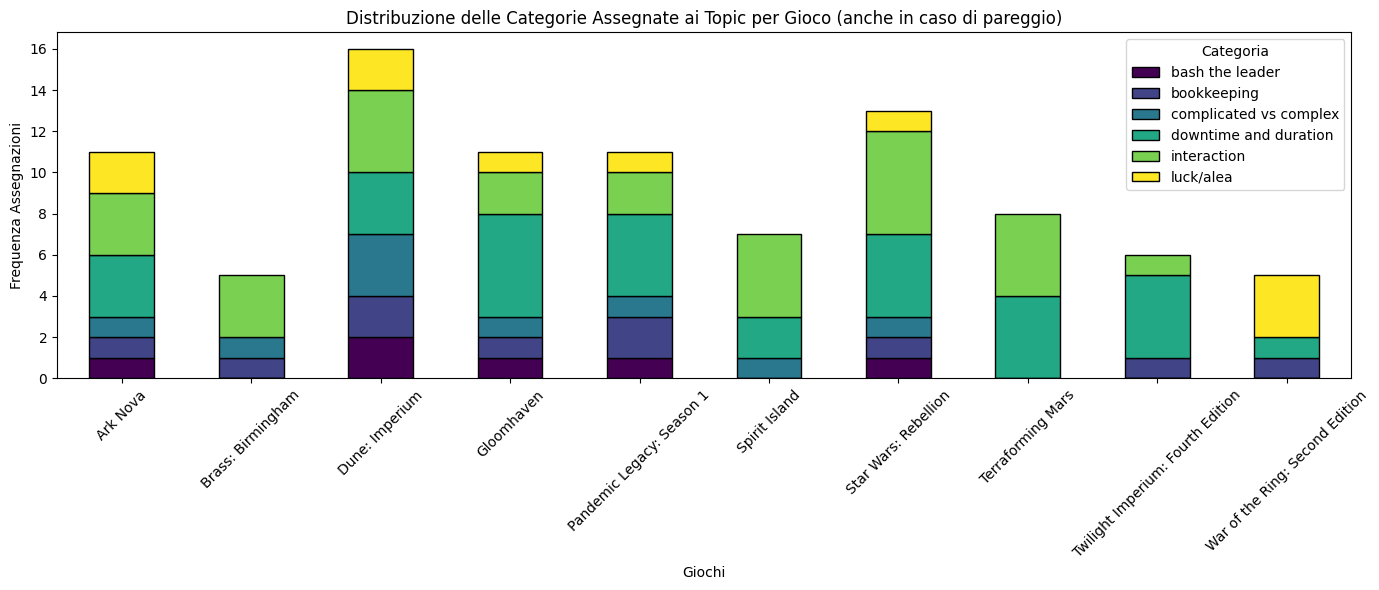

In [13]:
df_results["Game"] = df_results.index.str.split(" - ").str[0]


df_exploded = df_results.copy()
df_exploded["Assigned Category"] = df_exploded["Assigned Category"].str.split(", ")
df_exploded = df_exploded.explode("Assigned Category")


category_counts_per_game = df_exploded.groupby("Game")["Assigned Category"].value_counts().unstack().fillna(0)


plt.figure(figsize=(14, 6))
category_counts_per_game.plot(
    kind="bar", stacked=True, colormap="viridis", edgecolor="black", figsize=(14, 6)
)

plt.title("Distribuzione delle Categorie Assegnate ai Topic per Gioco (anche in caso di pareggio)")
plt.xlabel("Giochi")
plt.ylabel("Frequenza Assegnazioni")
plt.xticks(rotation=45)
plt.legend(title="Categoria")
plt.tight_layout()
plt.show()
